In [1]:
import re

import dask
import dask_awkward as dak
import uproot
from matplotlib import pyplot as plt
from coffea.lumi_tools import LumiMask

import egamma_tnp
from egamma_tnp.plot import plot_efficiency

In [34]:
def make_tnp_histograms(
    passing_probes,
    all_probes,
    plateau_cut,
    eta_regions_pt,
    eta_regions_eta,
    eta_regions_phi,
):
    import hist
    from hist.dask import Hist

    if plateau_cut is None:
        plateau_cut = 0
    if eta_regions_pt is None:
        eta_regions_pt = {
            "barrel": [0.0, 1.4442],
            "endcap": [1.566, 2.5],
        }
    if eta_regions_eta is None:
        eta_regions_eta = {"entire": [0, 2.5]}
    if eta_regions_phi is None:
        eta_regions_phi = {"entire": [0, 2.5]}

    ptbins = egamma_tnp.config.get("ptbins")
    etabins = egamma_tnp.config.get("etabins")
    phibins = egamma_tnp.config.get("phibins")

    pt_pass = passing_probes.pt
    pt_all = all_probes.pt
    eta_pass = passing_probes.eta
    eta_all = all_probes.eta
    phi_pass = passing_probes.phi
    phi_all = all_probes.phi

    histograms = {}
    histograms["pt"] = {}
    histograms["eta"] = {}
    histograms["phi"] = {}

    plateau_mask_pass = pt_pass > plateau_cut
    plateau_mask_all = pt_all > plateau_cut

    for name_pt, region_pt in eta_regions_pt.items():
        eta_mask_pt_pass = (abs(eta_pass) > region_pt[0]) & (
            abs(eta_pass) < region_pt[1]
        )
        eta_mask_pt_all = (abs(eta_all) > region_pt[0]) & (abs(eta_all) < region_pt[1])
        hpt_pass = Hist(
            hist.axis.Variable(ptbins, name=f"hpt_{name_pt}", label="Pt [GeV]")
        )
        hpt_all = Hist(
            hist.axis.Variable(ptbins, name=f"hpt_{name_pt}", label="Pt [GeV]")
        )
        hpt_pass.fill(pt_pass[eta_mask_pt_pass])
        hpt_all.fill(pt_all[eta_mask_pt_all])

        histograms["pt"][name_pt] = {"passing": hpt_pass, "all": hpt_all}

    for name_eta, region_eta in eta_regions_eta.items():
        eta_mask_eta_pass = (abs(eta_pass) > region_eta[0]) & (
            abs(eta_pass) < region_eta[1]
        )
        eta_mask_eta_all = (abs(eta_all) > region_eta[0]) & (
            abs(eta_all) < region_eta[1]
        )
        heta_pass = Hist(
            hist.axis.Variable(etabins, name=f"heta_{name_eta}", label="eta")
        )
        heta_all = Hist(
            hist.axis.Variable(etabins, name=f"heta_{name_eta}", label="eta")
        )
        heta_pass.fill(eta_pass[plateau_mask_pass & eta_mask_eta_pass])
        heta_all.fill(eta_all[plateau_mask_all & eta_mask_eta_all])

        histograms["eta"][name_eta] = {"passing": heta_pass, "all": heta_all}

    for name_phi, region_phi in eta_regions_phi.items():
        eta_mask_phi_pass = (abs(eta_pass) > region_phi[0]) & (
            abs(eta_pass) < region_phi[1]
        )
        eta_mask_phi_all = (abs(eta_all) > region_phi[0]) & (
            abs(eta_all) < region_phi[1]
        )
        hphi_pass = Hist(
            hist.axis.Variable(phibins, name=f"hphi_{name_phi}", label="phi")
        )
        hphi_all = Hist(
            hist.axis.Variable(phibins, name=f"hphi_{name_phi}", label="phi")
        )
        hphi_pass.fill(phi_pass[plateau_mask_pass & eta_mask_phi_pass])
        hphi_all.fill(phi_all[plateau_mask_all & eta_mask_phi_all])

        histograms["phi"][name_phi] = {"passing": hphi_pass, "all": hphi_all}

    return histograms


def find_pt_threshold(s):
    # Extract all numbers following "Ele" in the string
    numbers = re.findall(r"Ele(\d+)", s)

    # Convert extracted numbers to integers
    numbers = [int(num) for num in numbers]

    # If 'Leg1' is in the string, return the first number
    if "Leg1" in s:
        return numbers[0]
    # Otherwise, return the second number if there are two, else return the first
    else:
        return numbers[1] if len(numbers) > 1 else numbers[0]


def save_hists(path, res):
    with uproot.recreate(path) as f:
        for var, region_dict in res.items():
            for region_name, hists in region_dict.items():
                for i, (histname, h) in enumerate(hists.items()):
                    print(f"{region_name}/{histname} sum : {h.sum(flow=True)}")
                    f[f"{var}/{region_name}/{histname}"] = h


def find_probes(path, filter, goldenjson, extra_filter, extra_filter_args):
    events = uproot.dask({path: "tnpEleTrig/fitter_tree"})

    if extra_filter is not None:
        events = extra_filter(events, **extra_filter_args)

    if goldenjson is not None:
        lumimask = LumiMask(goldenjson)
        mask = lumimask(events.run, events.lumi)
        events = events[mask]

    pt = find_pt_threshold(filter) - 3
    pass_pt_tags = events.tag_Ele_pt > 35
    pass_pt_probes = events.el_pt > pt
    pass_tight_id = events.passingCutBasedTight122XV1 == 1
    in_mass_window = abs(events.pair_mass - 91.1876) < 30
    all_probe_events = events[
        pass_tight_id & in_mass_window & pass_pt_tags & pass_pt_probes
    ]
    passing_probe_events = all_probe_events[all_probe_events[filter] == 1]

    passing_probes = dak.zip(
        {
            "pt": passing_probe_events.el_pt,
            "eta": passing_probe_events.el_eta,
            "phi": passing_probe_events.el_phi,
        }
    )
    all_probes = dak.zip(
        {
            "pt": all_probe_events.el_pt,
            "eta": all_probe_events.el_eta,
            "phi": all_probe_events.el_phi,
        }
    )

    return passing_probes, all_probes


def get_tnp_histograms(
    path,
    filter,
    goldenjson=None,
    extra_filter=None,
    extra_filter_args=None,
    plateau_cut=None,
    eta_regions_pt=None,
    eta_regions_eta=None,
    eta_regions_phi=None,
    compute=True,
    progress=False,
):
    if extra_filter_args is None:
        extra_filter_args = {}

    passing_probes, all_probes = find_probes(
        path, filter, goldenjson, extra_filter, extra_filter_args
    )
    histograms = make_tnp_histograms(
        passing_probes,
        all_probes,
        plateau_cut,
        eta_regions_pt,
        eta_regions_eta,
        eta_regions_phi,
    )
    if compute:
        from dask.diagnostics import ProgressBar

        if progress:
            pbar = ProgressBar()
            pbar.register()

        res = dask.compute(histograms)[0]

        if progress:
            pbar.unregister()

        return res
    return histograms

In [ ]:
def filter_events_by_hlt_filter(events, hlt_filter):
    return events[events[hlt_filter] == 1]


seeded = [
    "hltEGL1SingleAndDoubleEGNonIsoOrWithEG26WithJetAndTauFilter",
    "hltEG33EtFilter",
    "hltEG33HEFilter",
    "hltEG33CaloIdLClusterShapeFilter",
    "hltEle33CaloIdLPixelMatchFilter",
]

unseeded = [
    "hltDiEG33EtUnseededFilter",
    "hltDiEG33HEUnseededFilter",
    "hltDiEG33CaloIdLClusterShapeUnseededFilter",
    "hltDiEle33CaloIdLPixelMatchUnseededFilter",
]

results = {}
for f in unseeded:
    hlt_filter = "pass" + f.replace("hlt", "HLT", 1)
    foo = get_tnp_histograms(
        "tnptuples/Run2022C.root",
        hlt_filter,
        goldenjson="json/Cert_Collisions2022_355100_362760_Golden.json",
        # extra_filter=filter_events_by_hlt_filter,
        # extra_filter_args={"hlt_filter": hlt_filter},
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=None,
        progress=True,
    )
    results[hlt_filter] = foo

In [ ]:
plt.figure()

for label, res in results.items():
    plot_efficiency(
        res["pt"]["barrel"]["passing"],
        res["pt"]["barrel"]["all"],
        label=label,
    )

plt.legend(frameon=False)
plt.xscale("log")
plt.ylim(0.0, 1.1)

plt.show()

In [45]:
hlt_paths = {
    "Ele30": "passHltEle30WPTightGsf",
    "Ele32": "passHltEle32WPTightGsf",
    "Ele115": "passHltEle115CaloIdVTGsfTrkIdTGsf",
    "Ele23Ele12Leg1": "passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg1L1match",
    "Ele23Ele12Leg2": "passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg2",
    "DoubleEle33SeededLeg": "passHltDoubleEle33CaloIdLMWSeedLegL1match",
    "DoubleEle33UnseededLeg": "passHltDoubleEle33CaloIdLMWUnsLeg",
}

In [46]:
for year in ["2022", "2023"]:
    path = f"tnptuples/data_EGamma_Run{year}.root"
    goldenjson = (
        "json/Cert_Collisions2022_355100_362760_Golden.json"
        if year == "2022"
        else "json/Cert_Collisions2023_366442_370790_Golden.json"
    )
    for name, filter in hlt_paths.items():
        if name == "Ele115":
            egamma_tnp.config.set(
                "ptbins",
                [
                    5,
                    10,
                    15,
                    20,
                    22,
                    26,
                    28,
                    30,
                    32,
                    34,
                    36,
                    38,
                    40,
                    45,
                    50,
                    60,
                    80,
                    100,
                    105,
                    110,
                    115,
                    120,
                    125,
                    130,
                    135,
                    140,
                    145,
                    150,
                    200,
                    250,
                    300,
                    350,
                    400,
                ],
            )
        else:
            egamma_tnp.config.set(
                "ptbins",
                [
                    5,
                    10,
                    12,
                    14,
                    16,
                    18,
                    20,
                    23,
                    26,
                    28,
                    30,
                    32,
                    34,
                    36,
                    38,
                    40,
                    45,
                    50,
                    60,
                    80,
                    100,
                    150,
                    250,
                    400,
                ],
            )

        pt = find_pt_threshold(filter)
        plateau_cut = pt + (5 - pt) % 5
        outfile = f"root_files/Run{year}_{name}_ntuples.root"
        print(f"Calculating efficiency of {filter} in Run{year}")
        res = get_tnp_histograms(
            path,
            filter,
            goldenjson=goldenjson,
            eta_regions_pt={
                "barrel": [0.0, 1.4442],
                "endcap_loweta": [1.566, 2.0],
                "endcap_higheta": [2.0, 2.5],
            },
            plateau_cut=plateau_cut,
            progress=True,
        )
        save_hists(outfile, res)

Calculating efficiency of passHltEle30WPTightGsf in Run2023C
[########################################] | 100% Completed | 106.58 ms
[########################################] | 100% Completed | 210.86 ms
[########################################] | 100% Completed | 312.07 ms
[########################################] | 100% Completed | 420.15 ms
[########################################] | 100% Completed | 525.38 ms
[########################################] | 100% Completed | 4.90 ss
[########################################] | 100% Completed | 5.01 s
[########################################] | 100% Completed | 5.11 s
[########################################] | 100% Completed | 5.22 s
[########################################] | 100% Completed | 5.32 s
barrel/passing sum : 4470514.0
barrel/all sum : 5789477.0
endcap_loweta/passing sum : 895696.0
endcap_loweta/all sum : 1172489.0
endcap_higheta/passing sum : 674252.0
endcap_higheta/all sum : 934302.0
entire/passing sum : 5544258.0
e

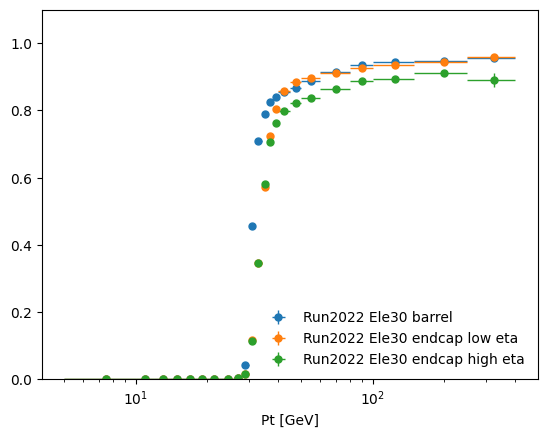

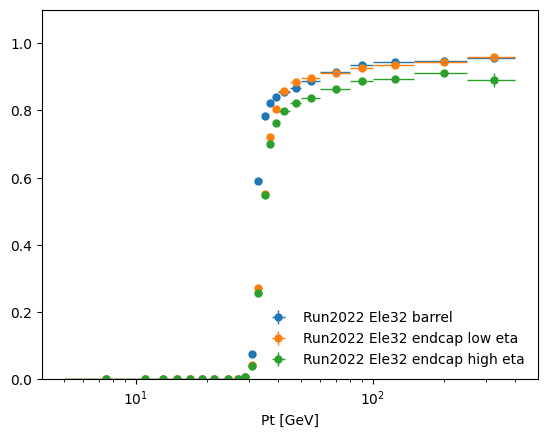

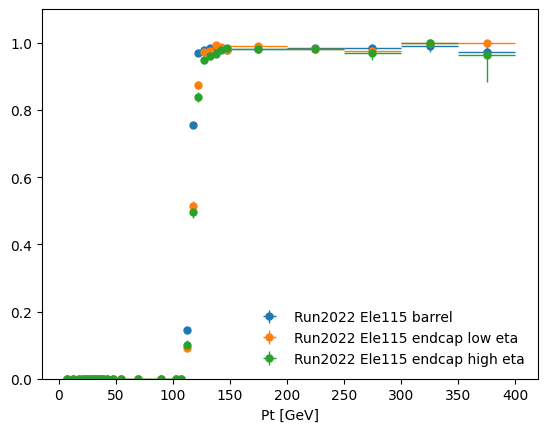

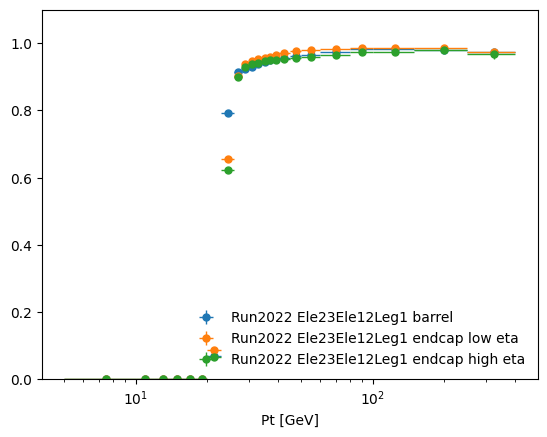

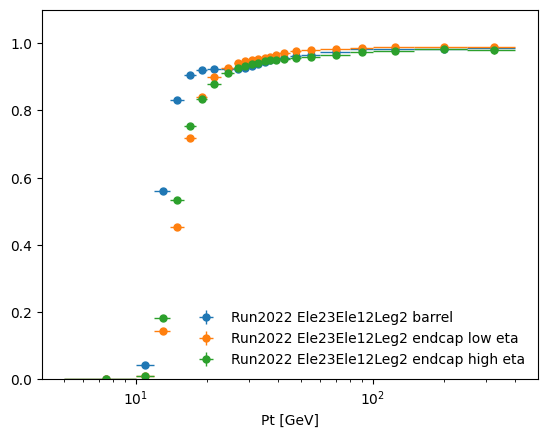

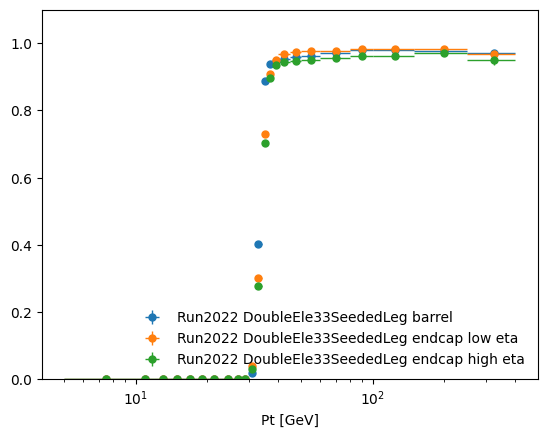

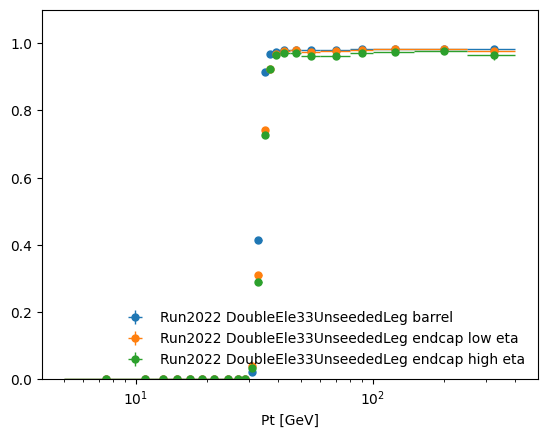

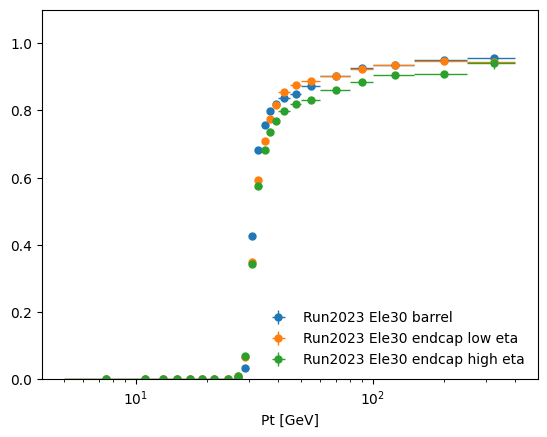

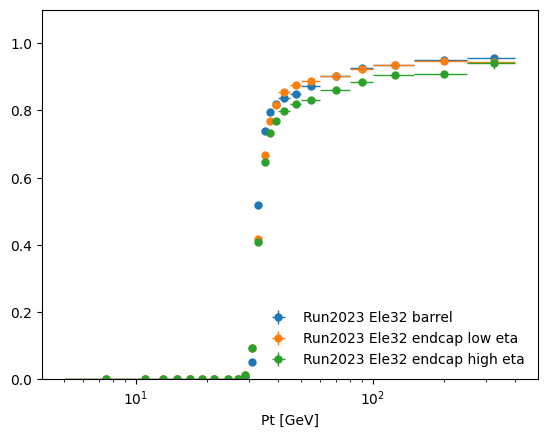

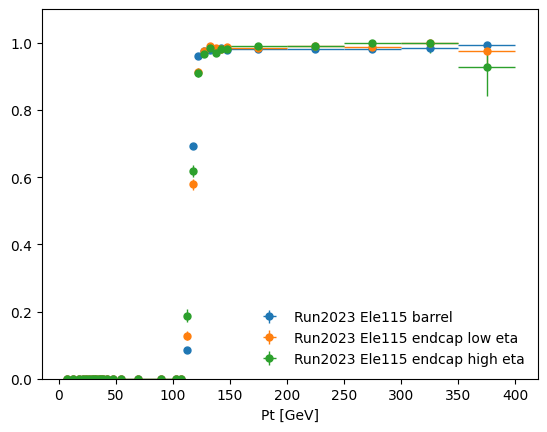

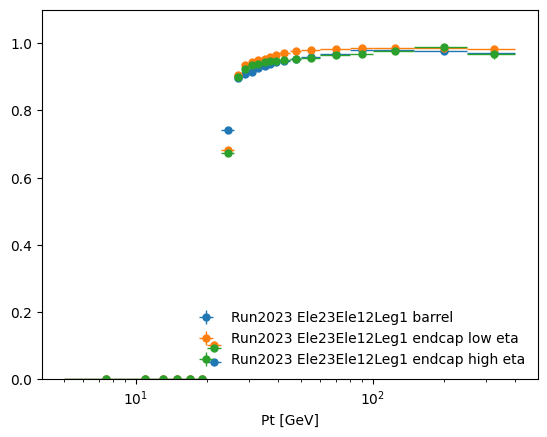

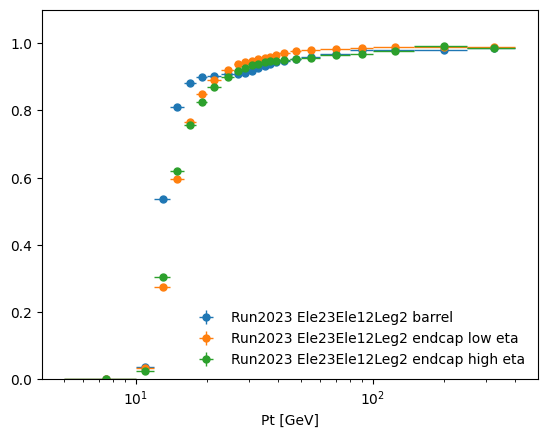

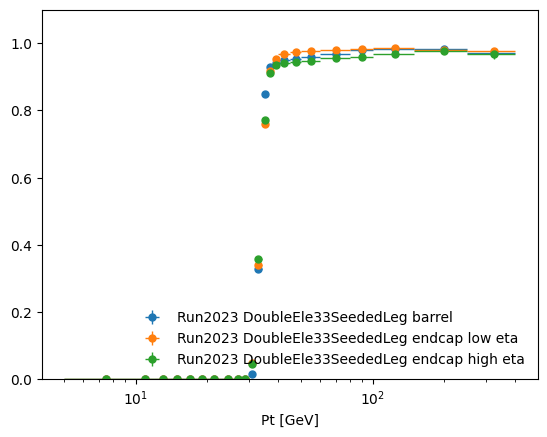

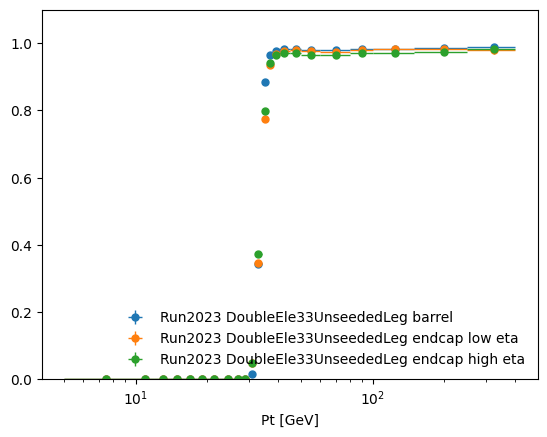

In [5]:
for year in ["2022", "2023"]:
    for name, filter in hlt_paths.items():
        outfile = f"root_files/Run{year}_{name}_ntuples.root"
        with uproot.open(outfile) as res:
            plt.figure()
            plot_efficiency(
                res["pt"]["barrel"]["passing"].to_hist(),
                res["pt"]["barrel"]["all"].to_hist(),
                label=f"Run{year} {name} barrel",
            )
            plot_efficiency(
                res["pt"]["endcap_loweta"]["passing"].to_hist(),
                res["pt"]["endcap_loweta"]["all"].to_hist(),
                label=f"Run{year} {name} endcap low eta",
            )
            plot_efficiency(
                res["pt"]["endcap_higheta"]["passing"].to_hist(),
                res["pt"]["endcap_higheta"]["all"].to_hist(),
                label=f"Run{year} {name} endcap high eta",
            )
            plt.legend(loc="lower right", frameon=False)
            plt.xscale("linear") if name == "Ele115" else plt.xscale("log")
            plt.ylim(0.0, 1.1)

            plt.show()

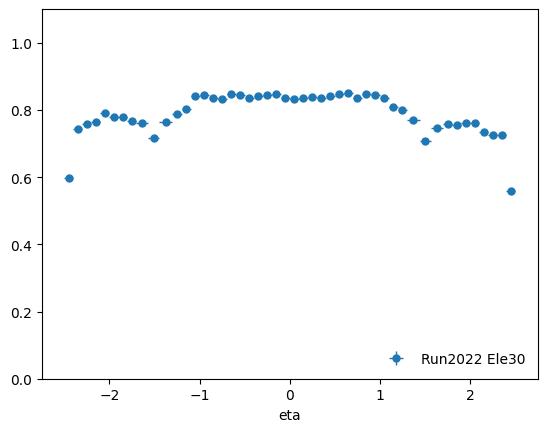

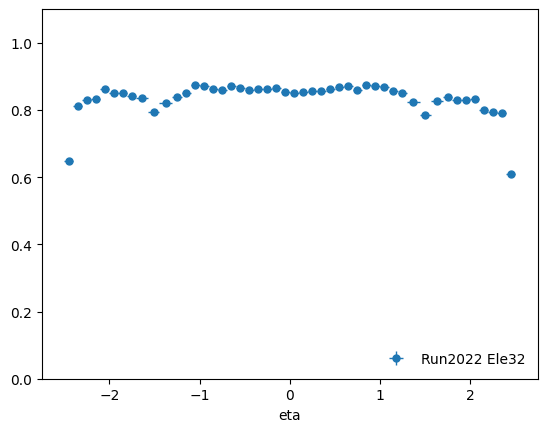

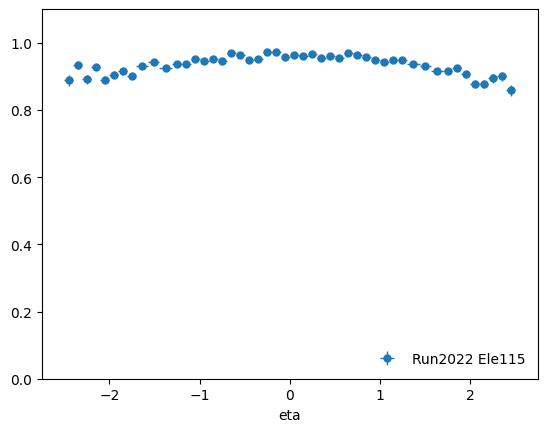

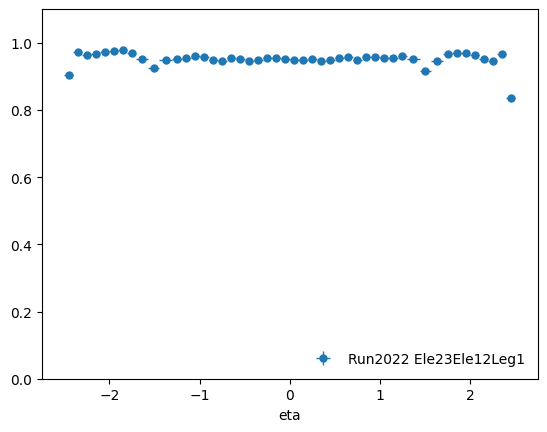

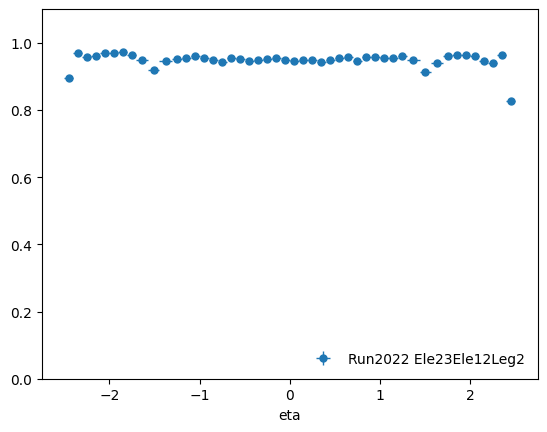

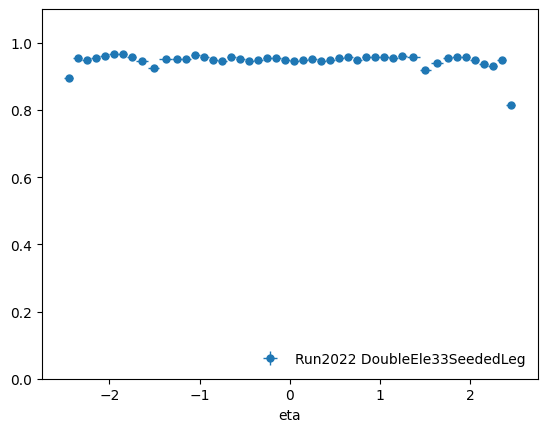

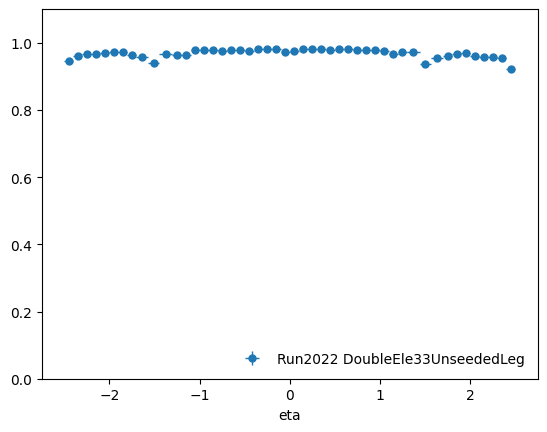

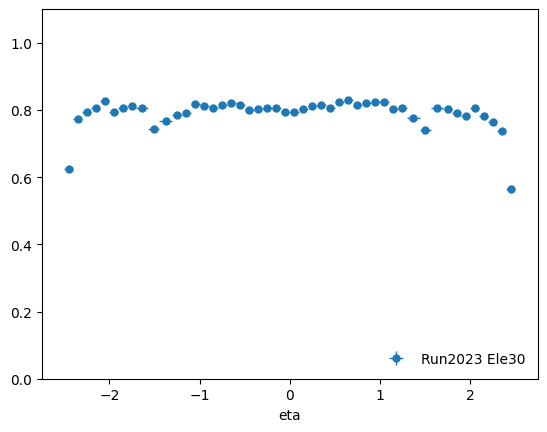

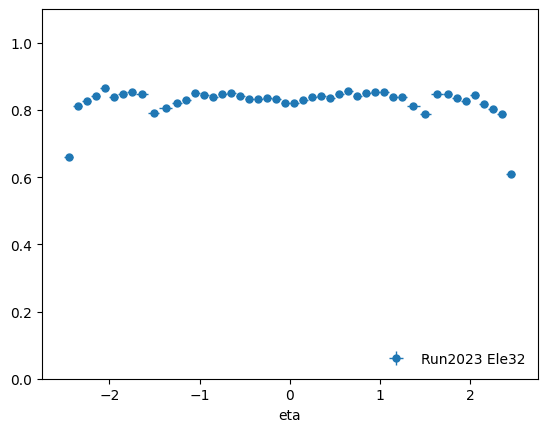

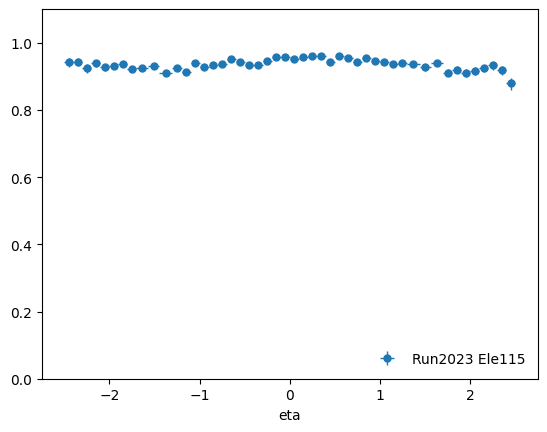

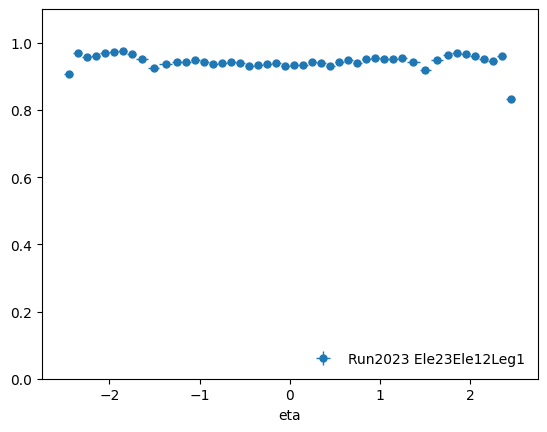

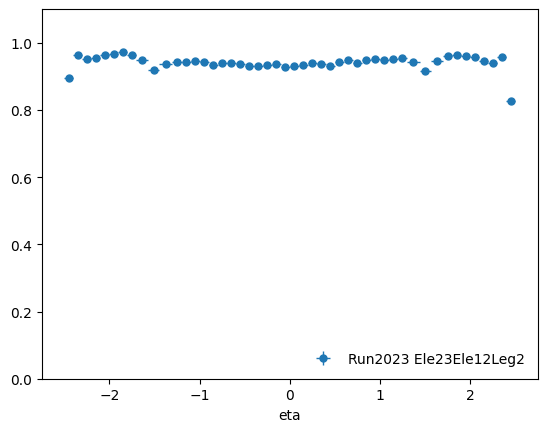

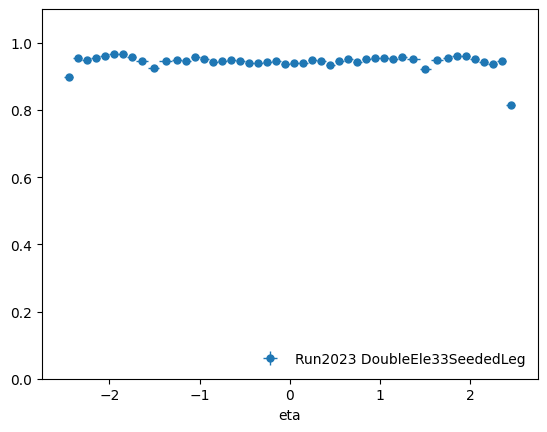

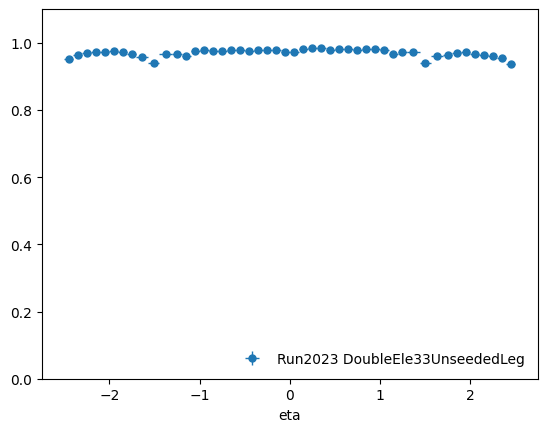

In [6]:
for year in ["2022", "2023"]:
    for name, filter in hlt_paths.items():
        outfile = f"root_files/Run{year}_{name}_ntuples.root"
        with uproot.open(outfile) as res:
            plt.figure()
            plot_efficiency(
                res["eta"]["entire"]["passing"].to_hist(),
                res["eta"]["entire"]["all"].to_hist(),
                label=f"Run{year} {name}",
            )
            plt.legend(loc="lower right", frameon=False)
            plt.ylim(0.0, 1.1)
            plt.show()

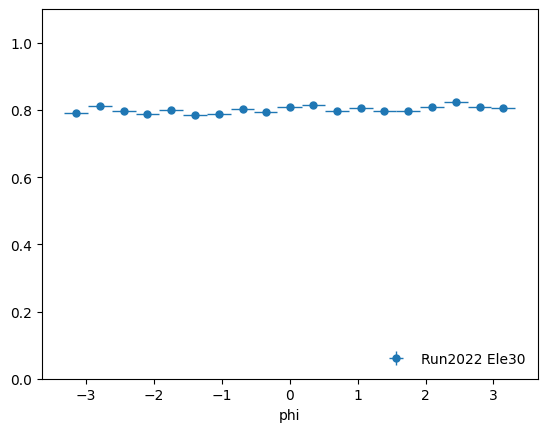

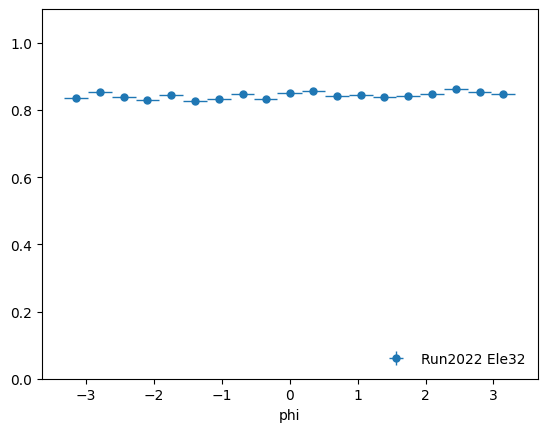

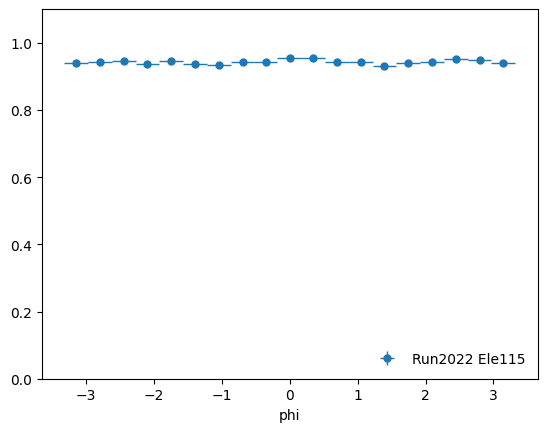

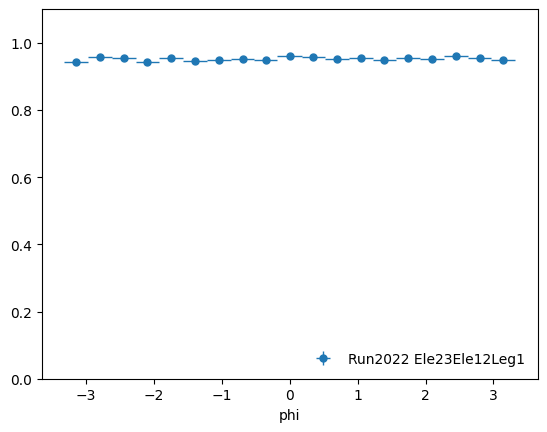

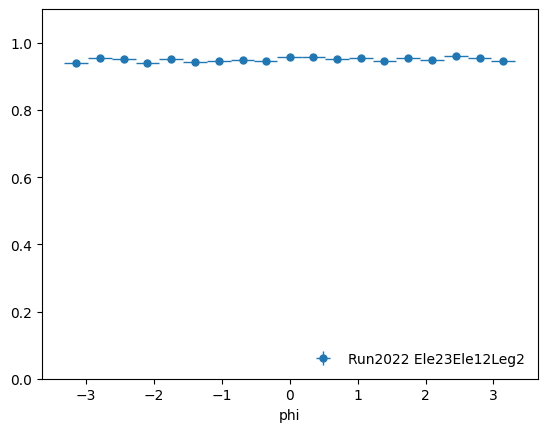

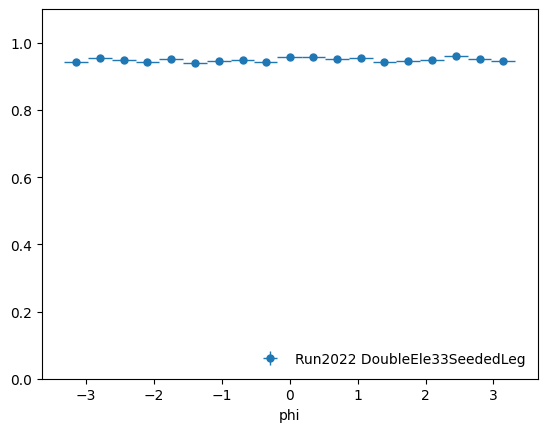

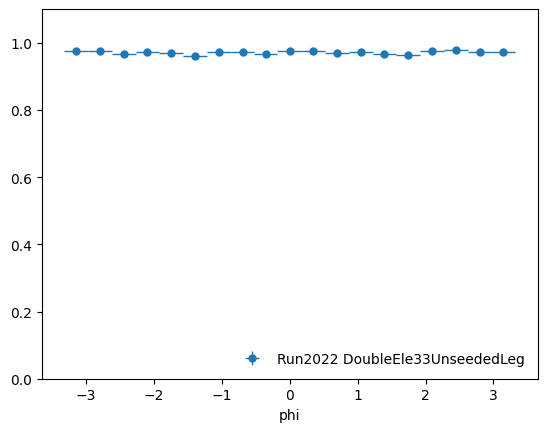

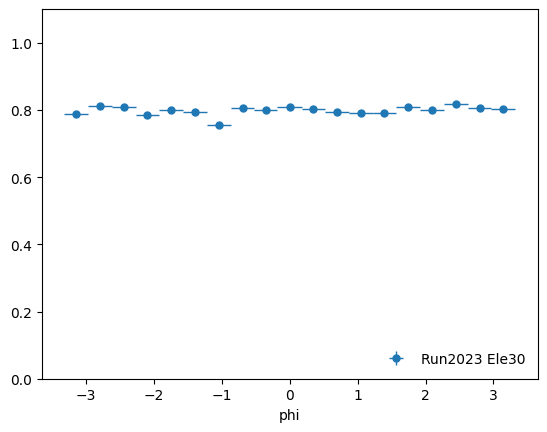

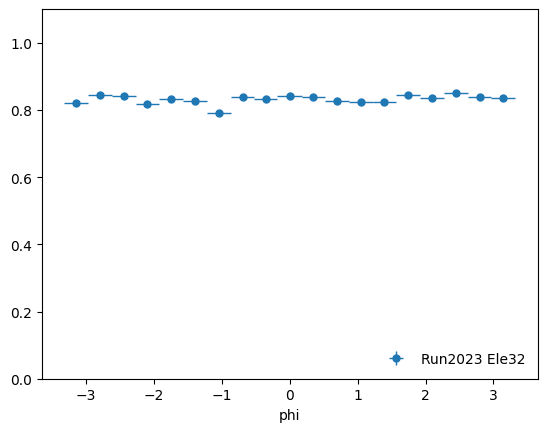

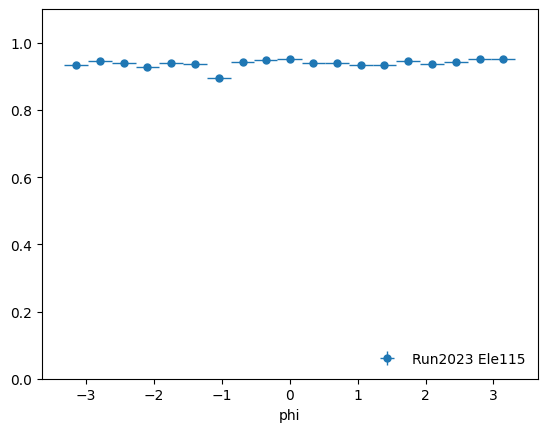

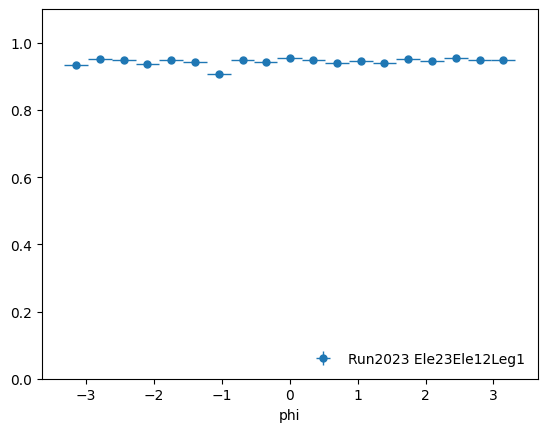

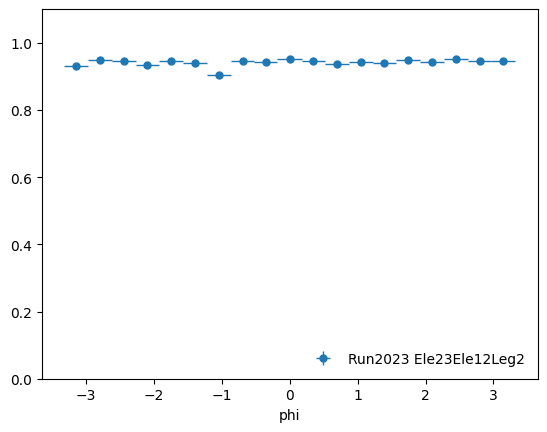

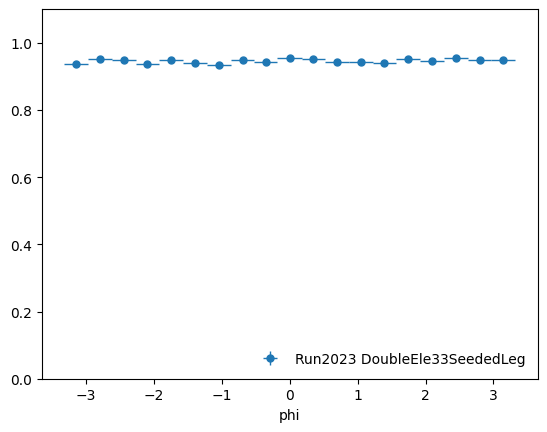

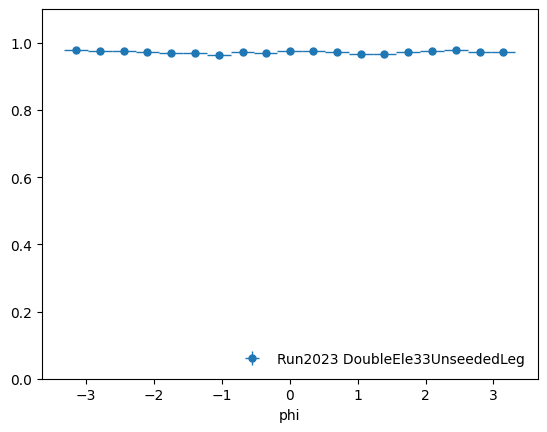

In [7]:
for year in ["2022", "2023"]:
    for name, filter in hlt_paths.items():
        outfile = f"root_files/Run{year}_{name}_ntuples.root"
        with uproot.open(outfile) as res:
            plt.figure()
            plot_efficiency(
                res["phi"]["entire"]["passing"].to_hist(),
                res["phi"]["entire"]["all"].to_hist(),
                label=f"Run{year} {name}",
            )
            plt.legend(loc="lower right", frameon=False)
            plt.ylim(0.0, 1.1)
            plt.show()

In [27]:
egamma_tnp.config.set(
    "ptbins",
    [
        5,
        10,
        12,
        14,
        16,
        18,
        20,
        23,
        26,
        28,
        30,
        32,
        34,
        36,
        38,
        40,
        45,
        50,
        60,
        80,
        100,
        150,
        250,
        400,
    ],
)

from filters import ele30_filters

results = {}
for f in ele30_filters[1:]:
    print(f"Calculating efficiencies of {f} in 2022 and 2023")
    res2022 = get_tnp_histograms(
        "tnptuples/data_EGamma_Run2022.root",
        "pass" + f.replace("hlt", "HLT", 1),
        goldenjson="json/Cert_Collisions2022_355100_362760_Golden.json",
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=35,
        progress=True,
    )
    res2023 = get_tnp_histograms(
        "tnptuples/data_EGamma_Run2023.root",
        "pass" + f.replace("hlt", "HLT", 1),
        goldenjson="json/Cert_Collisions2023_366442_370790_Golden.json",
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=35,
        progress=True,
    )

    results[f] = {"2022": res2022, "2023": res2023}

Calculating efficiencies of hltEG30L1SingleEGOrEtFilter in 2022 and 2023
[########################################] | 100% Completed | 104.13 ms
[########################################] | 100% Completed | 105.22 ms
[########################################] | 100% Completed | 209.98 ms
[########################################] | 100% Completed | 25.93 s
[########################################] | 100% Completed | 26.02 s
[########################################] | 100% Completed | 26.12 s
[########################################] | 100% Completed | 105.96 ms
[########################################] | 100% Completed | 210.57 ms
[########################################] | 100% Completed | 317.34 ms
[########################################] | 100% Completed | 20.36 s
[########################################] | 100% Completed | 20.47 s
[########################################] | 100% Completed | 20.57 s
Calculating efficiencies of hltEle30WPTightClusterShapeFilter in 2022 and 2

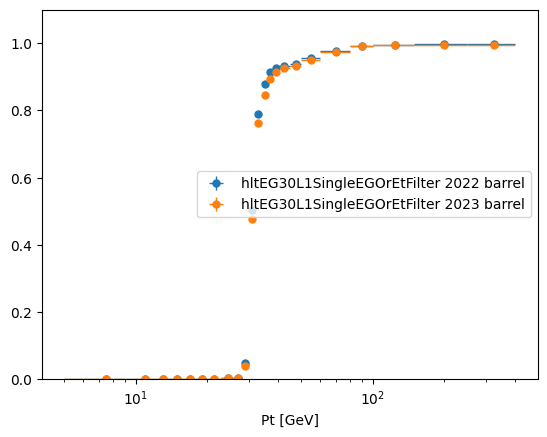

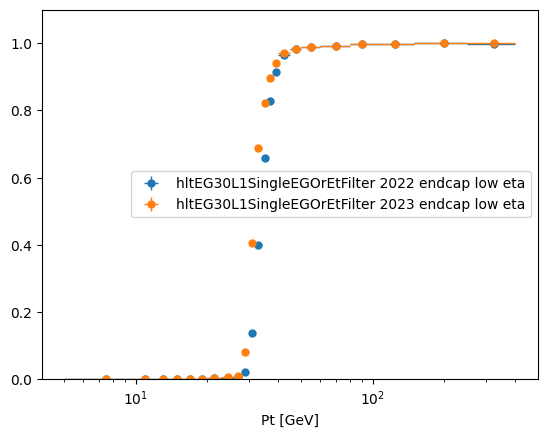

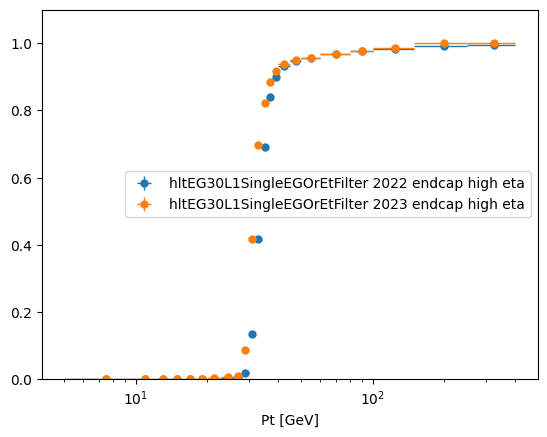

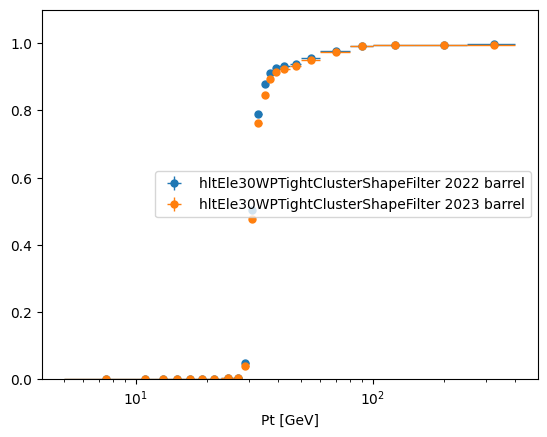

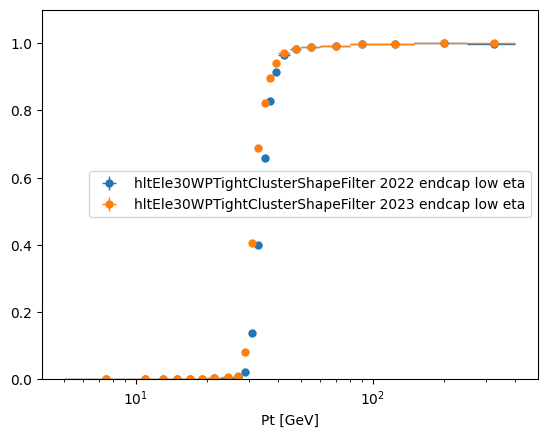

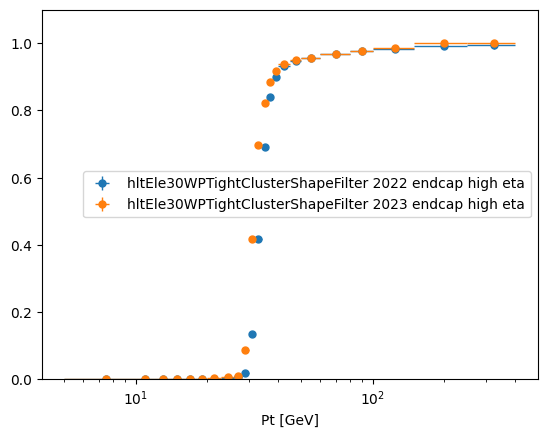

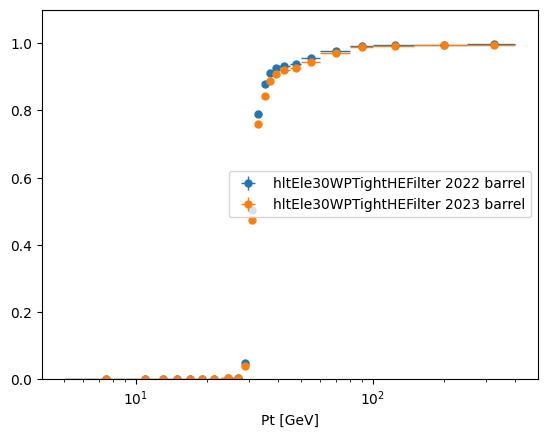

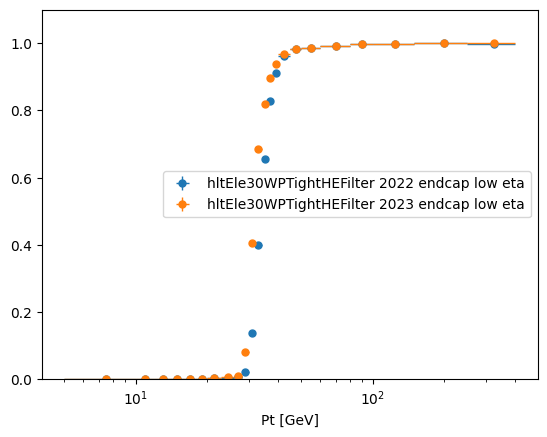

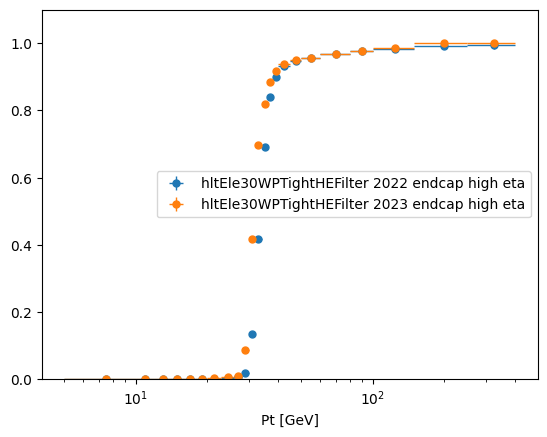

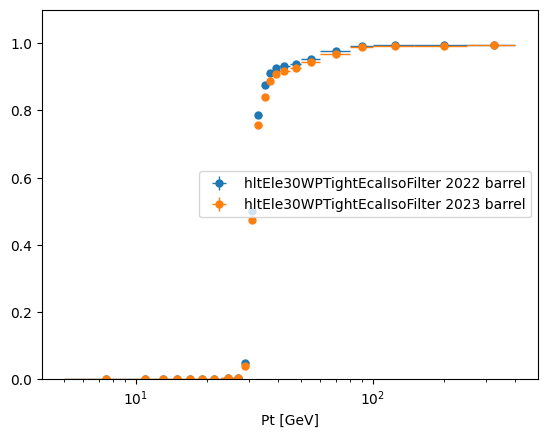

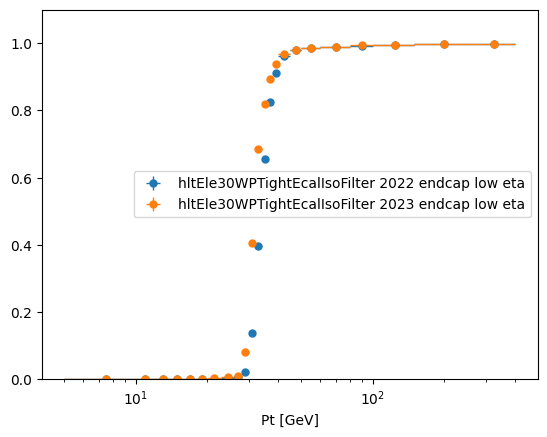

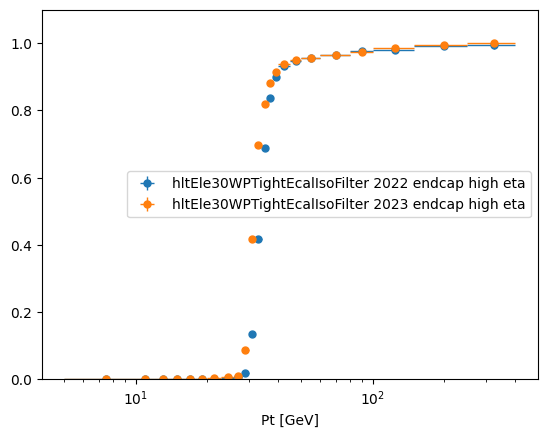

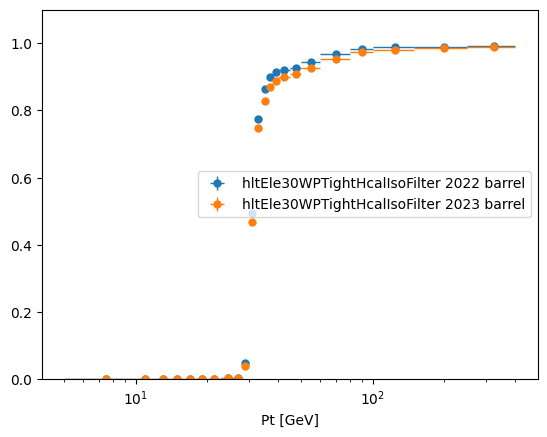

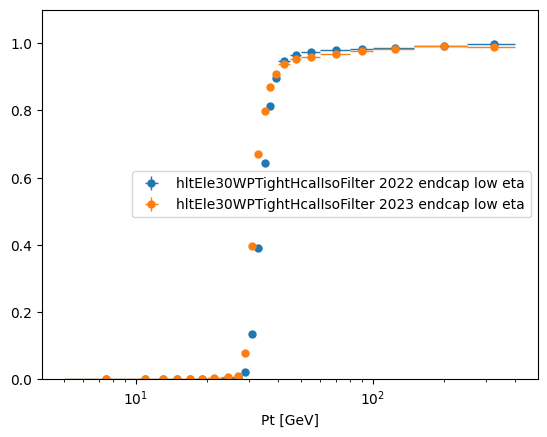

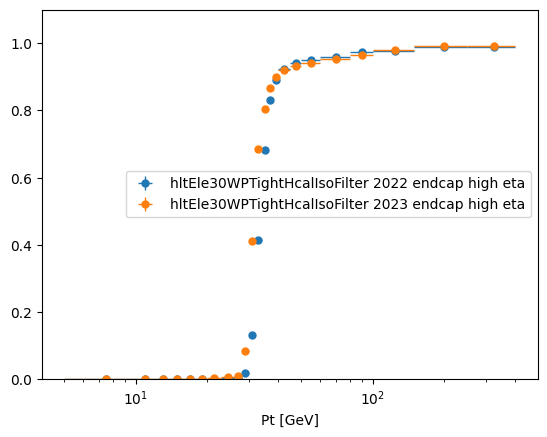

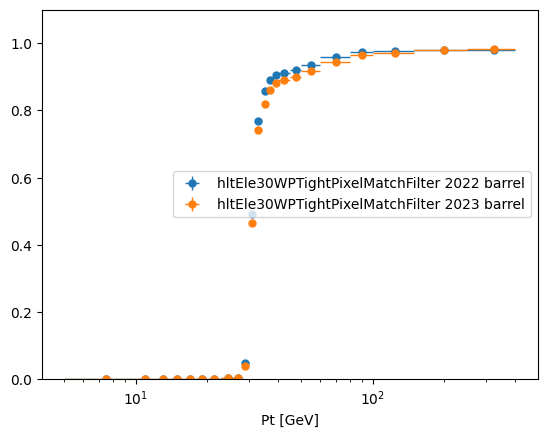

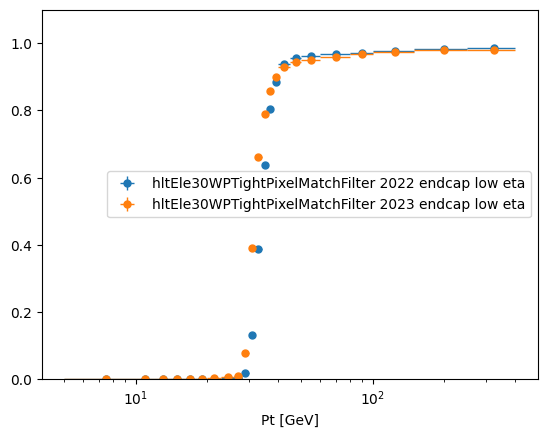

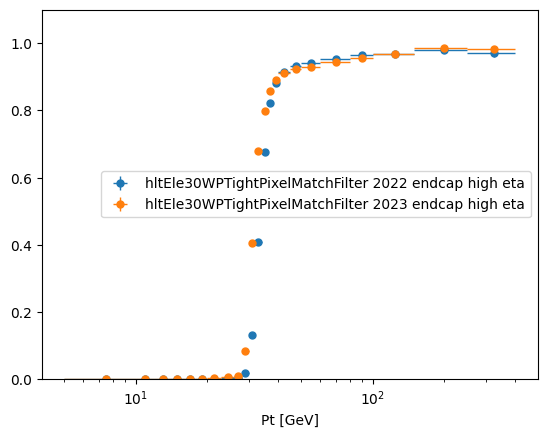

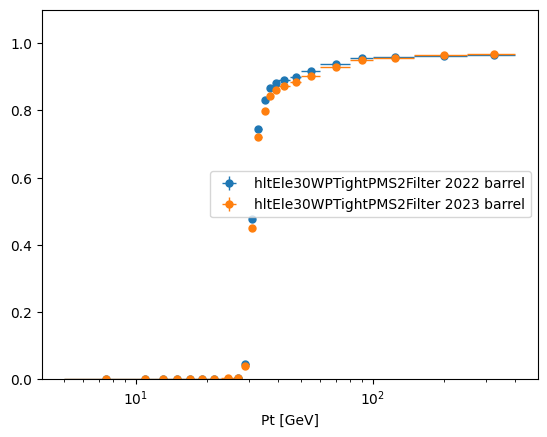

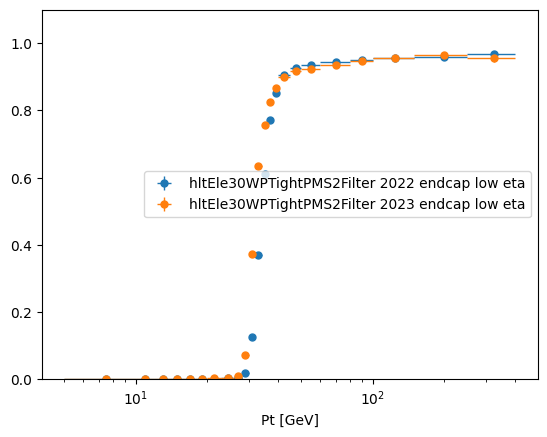

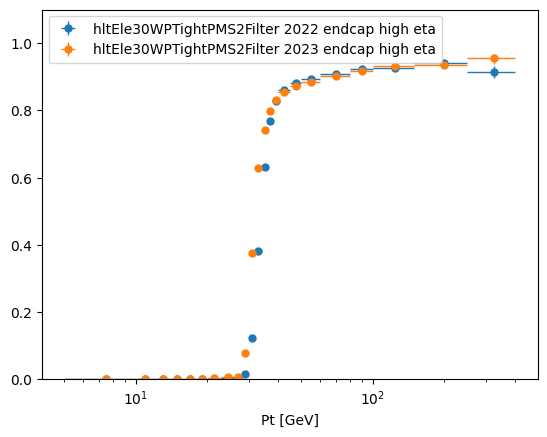

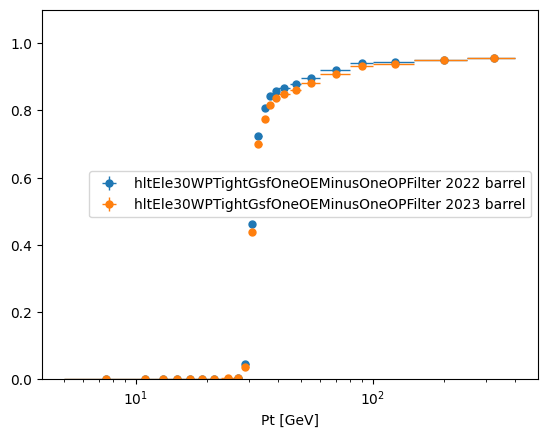

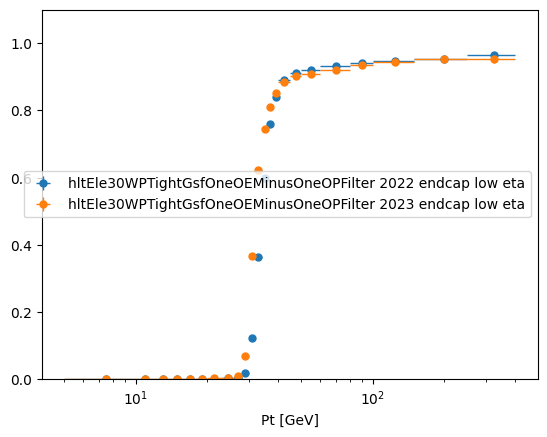

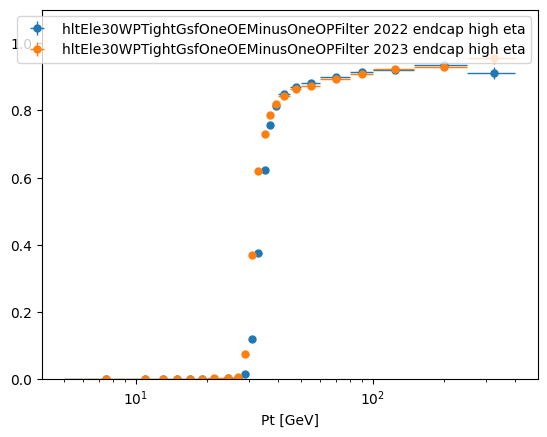

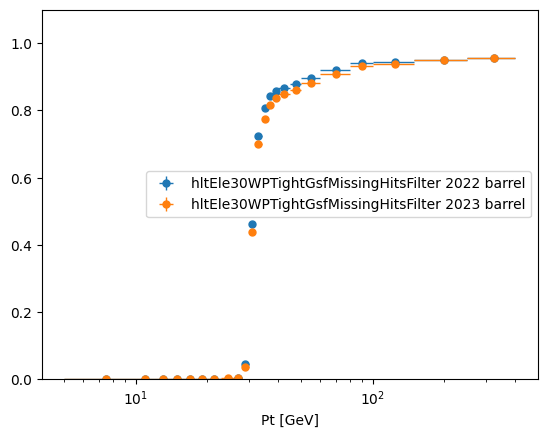

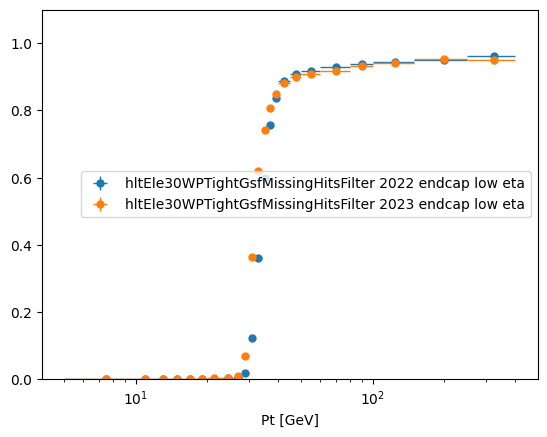

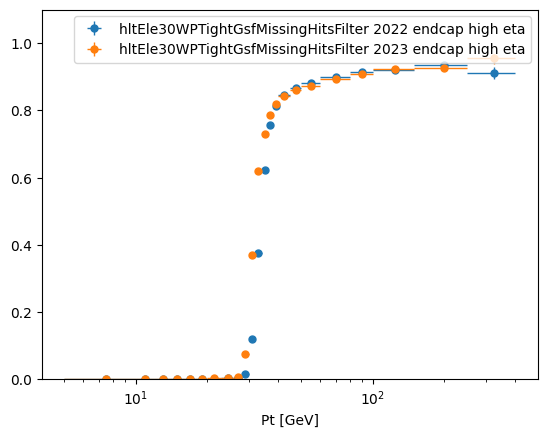

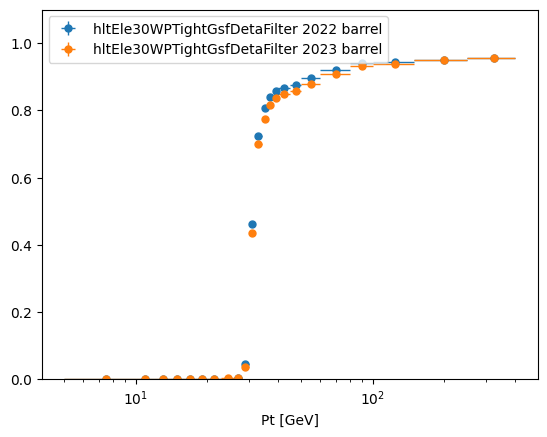

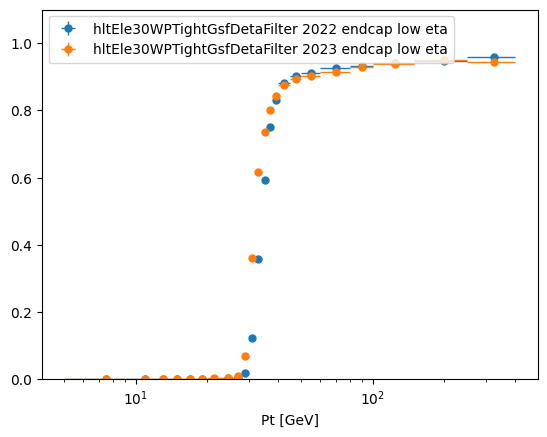

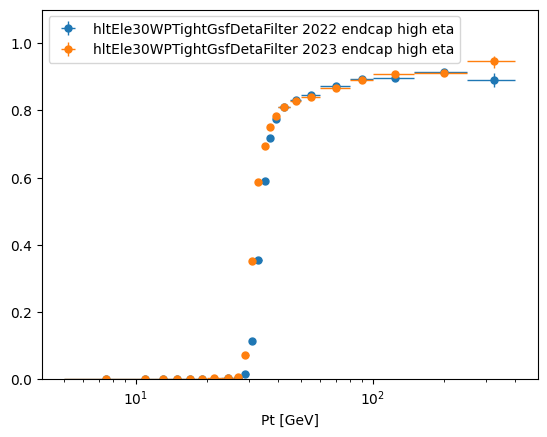

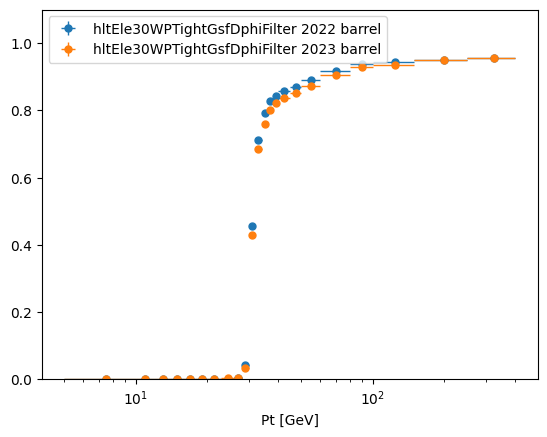

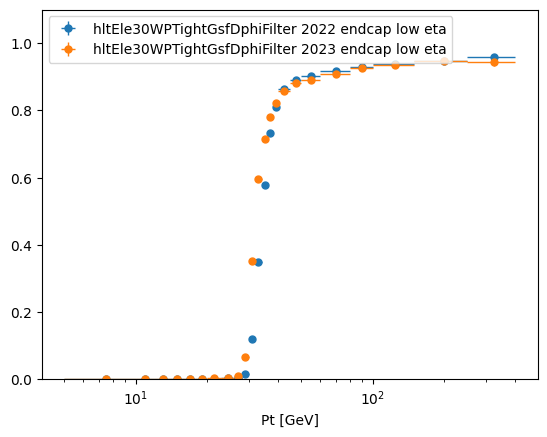

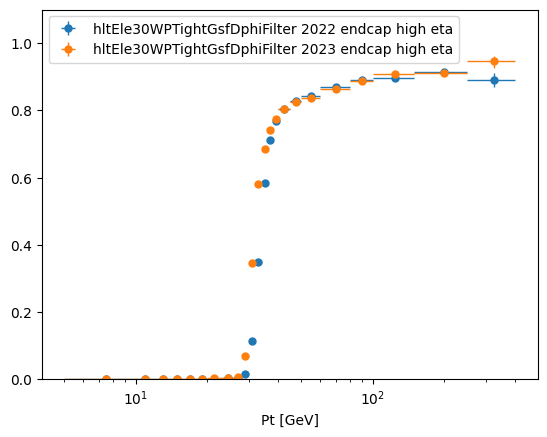

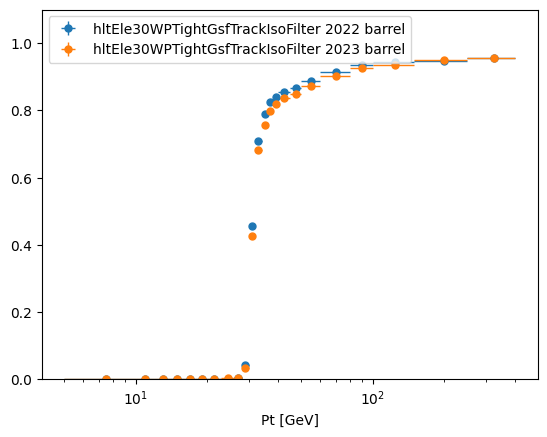

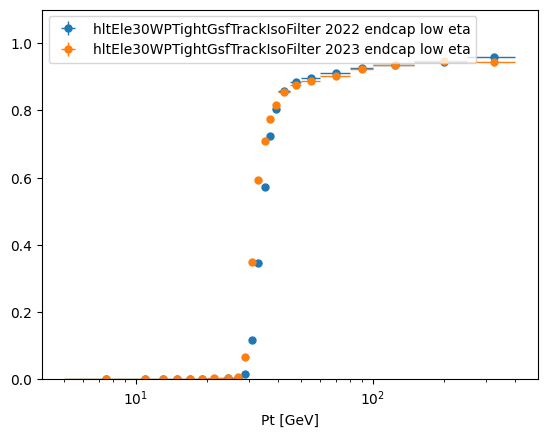

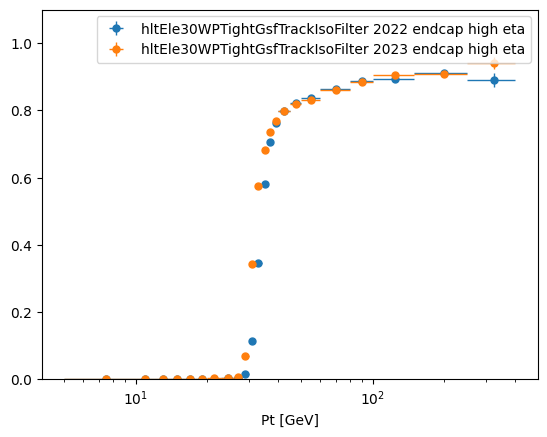

In [29]:
for f in ele30_filters[1:]:
    res2022 = results[f]["2022"]
    res2023 = results[f]["2023"]

    plt.figure()
    plot_efficiency(
        res2022["pt"]["barrel"]["passing"],
        res2022["pt"]["barrel"]["all"],
        label=f"{f} 2022 barrel",
    )
    plot_efficiency(
        res2023["pt"]["barrel"]["passing"],
        res2023["pt"]["barrel"]["all"],
        label=f"{f} 2023 barrel",
    )
    plt.legend()
    plt.xscale("log")
    plt.ylim(0.0, 1.1)
    plt.show()

    plt.figure()
    plot_efficiency(
        res2022["pt"]["endcap_loweta"]["passing"],
        res2022["pt"]["endcap_loweta"]["all"],
        label=f"{f} 2022 endcap low eta",
    )
    plot_efficiency(
        res2023["pt"]["endcap_loweta"]["passing"],
        res2023["pt"]["endcap_loweta"]["all"],
        label=f"{f} 2023 endcap low eta",
    )
    plt.legend()
    plt.xscale("log")
    plt.ylim(0.0, 1.1)
    plt.show()

    plt.figure()
    plot_efficiency(
        res2022["pt"]["endcap_higheta"]["passing"],
        res2022["pt"]["endcap_higheta"]["all"],
        label=f"{f} 2022 endcap high eta",
    )
    plot_efficiency(
        res2023["pt"]["endcap_higheta"]["passing"],
        res2023["pt"]["endcap_higheta"]["all"],
        label=f"{f} 2023 endcap high eta",
    )
    plt.legend()
    plt.xscale("log")
    plt.ylim(0.0, 1.1)
    plt.show()

In [40]:
res = get_tnp_histograms(
    "tnptuples/data_EGamma_Run2023.root",
    "passHltEle30WPTightGsf",
    goldenjson="json/Cert_Collisions2023_366442_370790_Golden.json",
    eta_regions_pt={
        "barrel": [0.0, 1.4442],
        "endcap_loweta": [1.566, 2.0],
        "endcap_higheta": [2.0, 2.5],
    },
    plateau_cut=35,
    progress=True,
)

[########################################] | 100% Completed | 106.12 ms
[########################################] | 100% Completed | 210.84 ms
[########################################] | 100% Completed | 317.39 ms
[########################################] | 100% Completed | 417.87 ms
[########################################] | 100% Completed | 19.20 s
[########################################] | 100% Completed | 19.30 s
[########################################] | 100% Completed | 19.40 s
[########################################] | 100% Completed | 19.51 s


In [41]:
save_hists("tnptuples/Ele30_2023.root", res)

barrel/passing sum : 6938477.0
barrel/all sum : 9031101.0
endcap_loweta/passing sum : 1391584.0
endcap_loweta/all sum : 1827397.0
endcap_higheta/passing sum : 1045373.0
endcap_higheta/all sum : 1454724.0
entire/passing sum : 8604171.0
entire/all sum : 10327933.0
entire/passing sum : 8604171.0
entire/all sum : 10327933.0


In [ ]:
plt.figure()
plot_efficiency(
    res["pt"]["barrel"]["passing"],
    res["pt"]["barrel"]["all"],
    label="barrel",
)
plot_efficiency(
    res["pt"]["endcap_loweta"]["passing"],
    res["pt"]["endcap_loweta"]["all"],
    label="endcap low eta",
)
plot_efficiency(
    res["pt"]["endcap_higheta"]["passing"],
    res["pt"]["endcap_higheta"]["all"],
    label="endcap high eta",
)
plt.legend()
plt.xscale("log")
plt.ylim(0.0, 1.1)

plt.show()

In [ ]:
plt.figure()
plot_efficiency(
    res["eta"]["entire"]["passing"],
    res["eta"]["entire"]["all"],
)
plt.ylim(0.0, 1.1)
plt.show()

In [ ]:
plt.figure()
plot_efficiency(
    res["phi"]["entire"]["passing"],
    res["phi"]["entire"]["all"],
)
plt.ylim(0.0, 1.1)
plt.show()

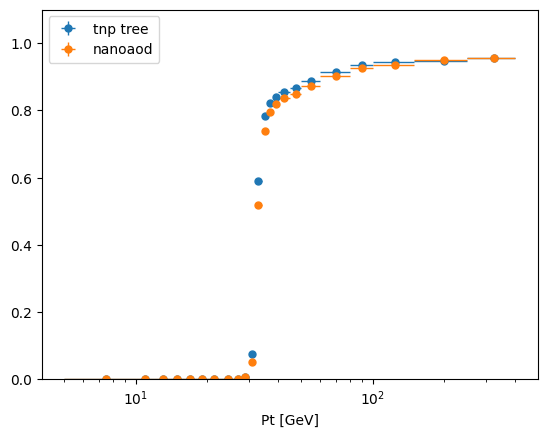

In [11]:
plt.figure()
plot_efficiency(
    res["pt"]["barrel"]["passing"],
    res["pt"]["barrel"]["all"],
    label="tnp tree",
)
with uproot.open("tnptuples/Run2023D_Ele30.root") as f:
    plot_efficiency(
        f["pt"]["barrel"]["passing"].to_hist(),
        f["pt"]["barrel"]["all"].to_hist(),
        label="nanoaod",
    )
plt.legend()
plt.xscale("log")
plt.ylim(0.0, 1.1)

plt.show()

In [ ]:
plt.figure()
plot_efficiency(
    res["eta"]["entire"]["passing"],
    res["eta"]["entire"]["all"],
    label="tnp tree",
)
with uproot.open("root_files/Run2023D_Ele30.root") as f:
    plot_efficiency(
        f["eta"]["entire"]["passing"].to_hist(),
        f["eta"]["entire"]["all"].to_hist(),
        label="nanoaod",
    )
plt.legend()
plt.ylim(0.0, 1.1)

plt.show()

In [ ]:
plt.figure()
plot_efficiency(
    res["phi"]["entire"]["passing"],
    res["phi"]["entire"]["all"],
    label="tnp tree",
)
with uproot.open("root_files/Run2023D_Ele30.root") as f:
    plot_efficiency(
        f["phi"]["entire"]["passing"].to_hist(),
        f["phi"]["entire"]["all"].to_hist(),
        label="nanoaod",
    )
plt.legend()
plt.ylim(0.0, 1.1)

plt.show()